In [1]:
!pip install pycocotools
!pip install faster-coco-eval
!git clone https://github.com/bxt-kk/vikit-learn.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 9.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 kB 9.8 MB/s eta 0:00:00ta 0:00:01
Cloning into 'vikit-learn'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 167 (delta 86), reused 124 (delta 47), pack-reused 0
Receiving objects: 100% (167/167), 42.44 KiB | 14.14 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [2]:
!mkdir /kaggle/working/OxfordIIITPet
!ln -sv \
 /kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/annotations/annotations \
 /kaggle/working/OxfordIIITPet/
!ln -sv \
 /kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/images/images \
 /kaggle/working/OxfordIIITPet/

'/kaggle/working/OxfordIIITPet/annotations' -> '/kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/annotations/annotations'
'/kaggle/working/OxfordIIITPet/images' -> '/kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/images/images'


In [3]:
import sys

sys.path.append(
    '/kaggle/working/vikit-learn/')

In [4]:
import torch
torch.manual_seed(3)
from torch.utils.data import DataLoader

from vklearn.trainer.trainer import Trainer
from vklearn.trainer.tasks import Detection
from vklearn.models.trimnetx import TrimNetX as TRBNetX
from vklearn.datasets.oxford_iiit_pet import OxfordIIITPet

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TRBNetX(
    num_classes=2,
    anchors=[(a, a) for a in [21, 63, 189]],
    backbone_pretrained=True,
)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 51.6MB/s]


In [6]:
dataset_root = '/kaggle/working/OxfordIIITPet'
dataset_type = 'detection'

train_transforms, test_transforms = model.get_transforms('oxford_iiit_pet_det')

train_data = OxfordIIITPet(
    dataset_root,
    split='trainval',
    target_types=dataset_type,
    transforms=train_transforms)
test_data = OxfordIIITPet(
    dataset_root,
    split='trainval',
    target_types=dataset_type,
    transforms=test_transforms)

batch_size = 16

train_loader = DataLoader(
    train_data, batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=model.collate_fn,
    num_workers=4)
test_loader = DataLoader(
    test_data, batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=model.collate_fn,
    num_workers=4)

print(len(train_loader))

229


In [7]:
task = Detection(
    model, device, metric_start_epoch=0, fit_features_start=0,
    loss_options={'weights': dict(conf=0.5, bbox=1.5, clss=0.5)},
    # score_options={'conf_thresh': 0.5},
    # metric_options={'conf_thresh': 0.5},
)
trainer = Trainer(
    task,
    output='/kaggle/working/catdog',
    checkpoint=None,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=5,
    lr=1e-3,
    show_step=50,
    save_epoch=5)

trainer.initialize()

Preparing ...
device: cuda
train dataset: Dataset OxfordIIITPet
    Number of datapoints: 3671
    Root location: /kaggle/working/OxfordIIITPet
    Compose(
      ToImage()
      ScaleJitter(target_size=(448, 448), scale_range=(0.9, 1.1), interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomPhotometricDistort(brightness=(0.875, 1.125), contrast=(0.5, 1.5), hue=(-0.05, 0.05), saturation=(0.5, 1.5), p=1)
      RandomHorizontalFlip(p=0.5)
      RandomCrop(size=(448, 448), pad_if_needed=True, padding_mode=constant)
      SanitizeBoundingBoxes(min_size=5, labels_getter=default)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)
{'batch_size': 16, 'num_workers': 4}
test dataset: Dataset OxfordIIITPet
    Number of datapoints: 3671
    Root location: /kaggle/working/OxfordIIITPet
    Compose(
      ToImage()
      Resize(size=[447], interpolation=InterpolationMode.BILINEAR, max_size=448, antialias=True)
      Cent

--------------------------------------------------------------------------------
Training ...
train mode: True
epoch: 1/5, step: 50/229
{"train": {"loss": 1.72597, "conf_loss": 1.32582, "bbox_loss": 0.57834, "clss_loss": 0.39111, "sampled_loss": 0.23278, "conf_precision": 0.00582, "conf_recall": 0.76375, "conf_f1": 0.01152, "iou_score": 0.46668, "clss_accuracy": 0.82, "proposals": 185.8275, "obj_conf_min": 0.50743}}
epoch: 1/5, step: 100/229
{"train": {"loss": 1.48474, "conf_loss": 1.11661, "bbox_loss": 0.51434, "clss_loss": 0.30983, "sampled_loss": 0.15212, "conf_precision": 0.01592, "conf_recall": 0.77063, "conf_f1": 0.0308, "iou_score": 0.51772, "clss_accuracy": 0.86313, "proposals": 109.01313, "obj_conf_min": 0.59526}}
epoch: 1/5, step: 150/229
{"train": {"loss": 1.33337, "conf_loss": 1.02462, "bbox_loss": 0.46069, "clss_loss": 0.26003, "sampled_loss": 0.12558, "conf_precision": 0.02463, "conf_recall": 0.76875, "conf_f1": 0.04679, "iou_score": 0.56488, "clss_accuracy": 0.88833, "pr

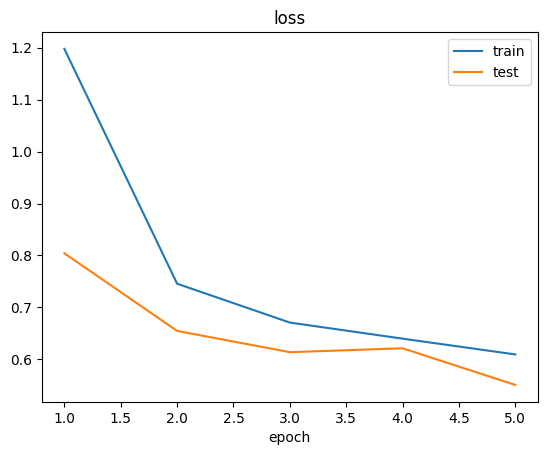

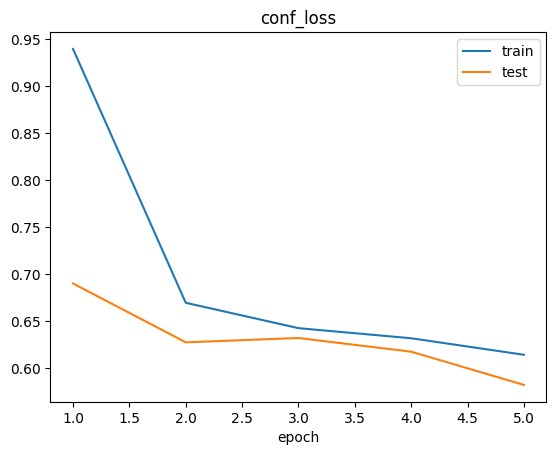

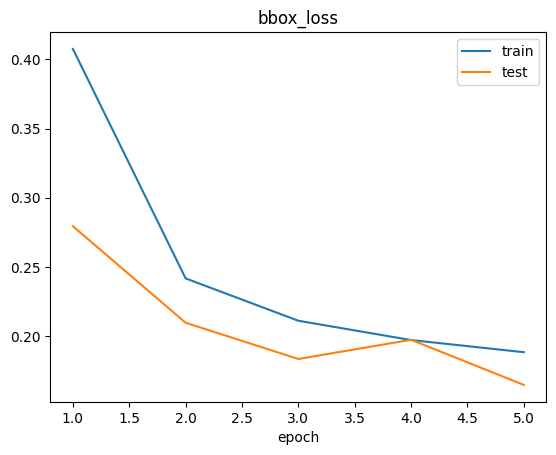

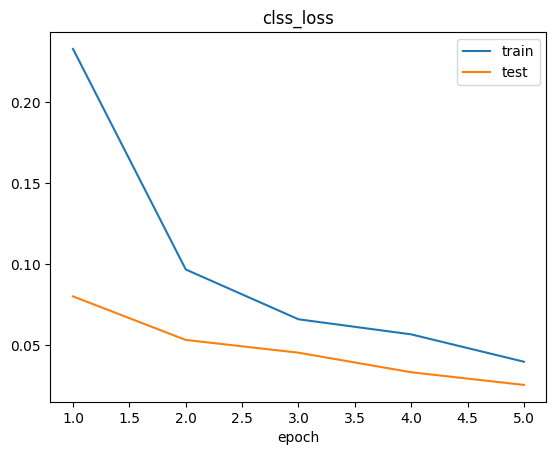

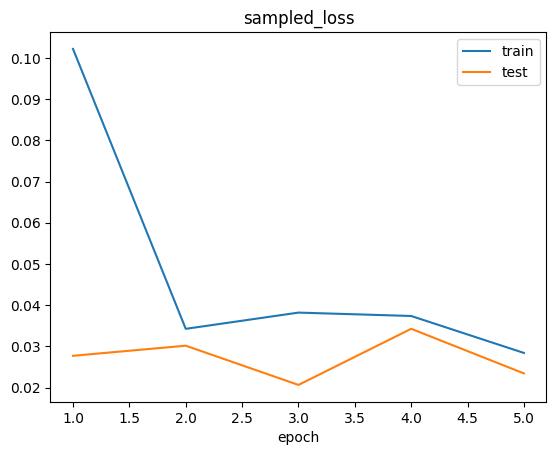

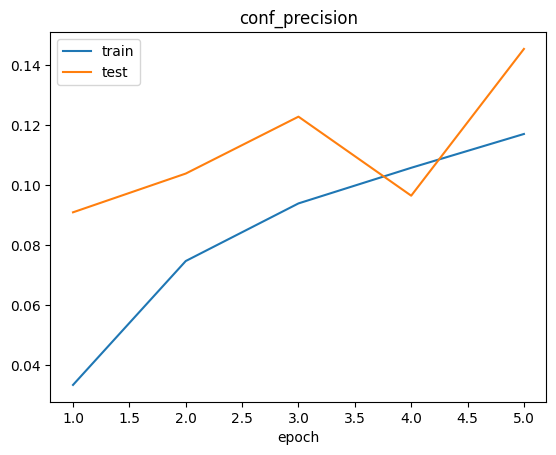

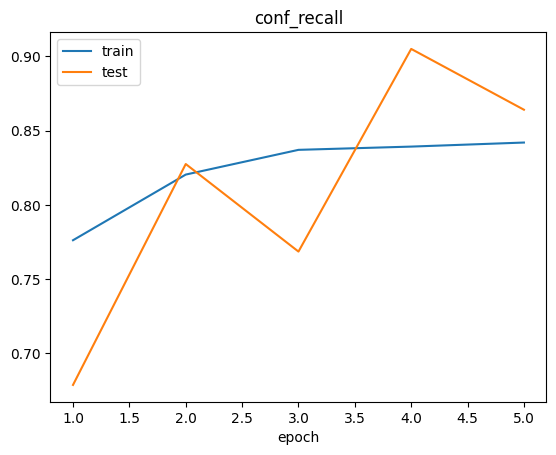

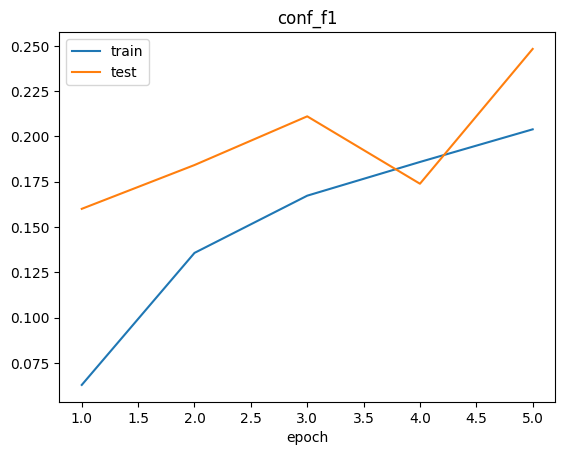

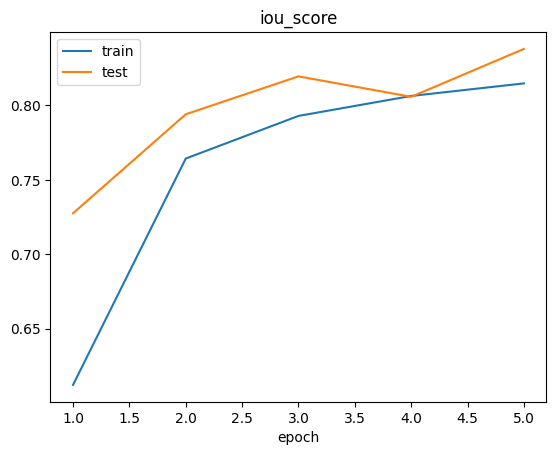

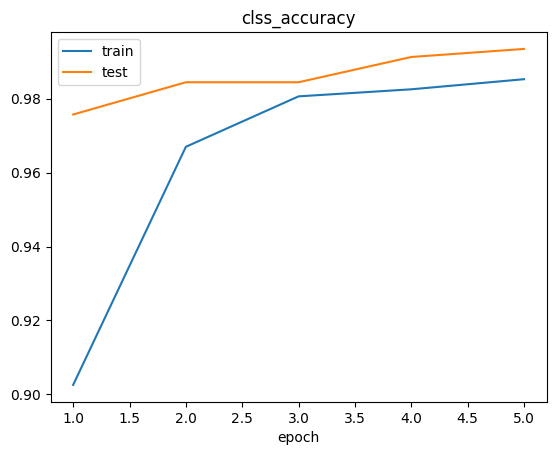

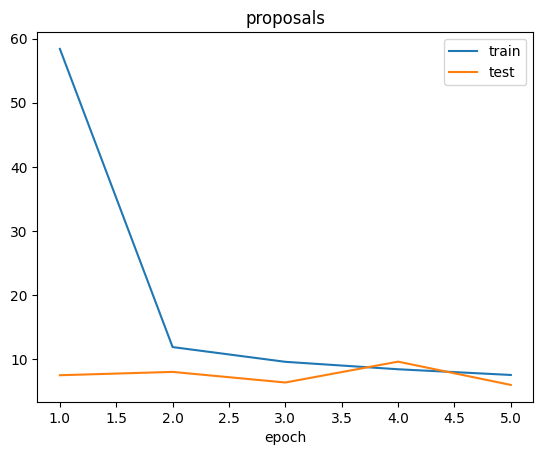

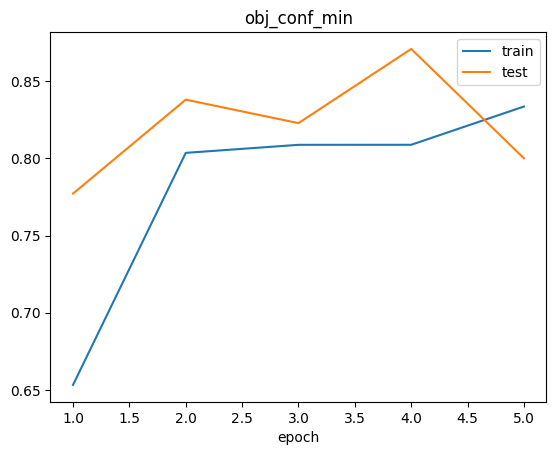

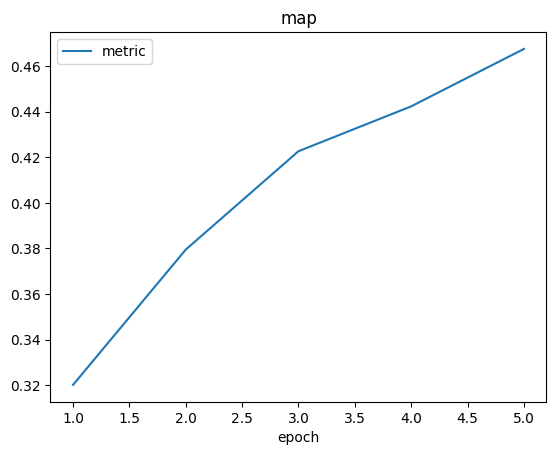

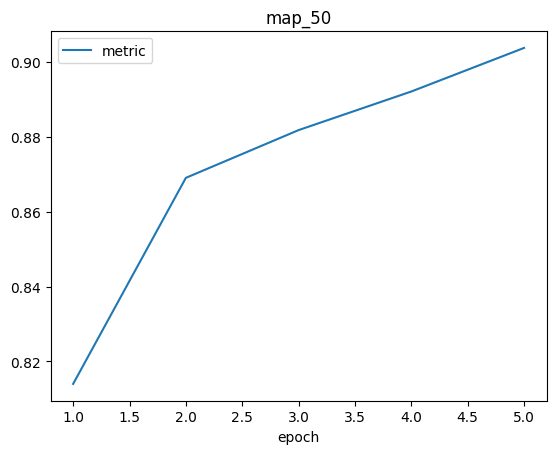

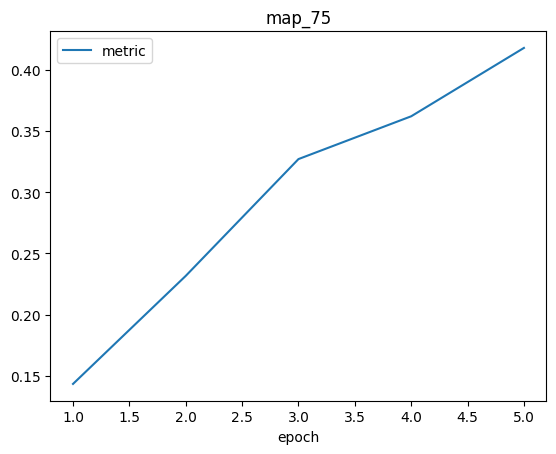

In [8]:
trainer.fit(max_train_step=0, max_test_step=0)